In [1]:
#Inception11 is the best model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
import cv2
import math
import numpy as np
import os
import pandas as pd
import pickle
import random
import tensorflow as tf
from collections import Counter
from matplotlib import cm
from matplotlib.pyplot import plot
from more_itertools import locate
from PIL import Image
from sklearn.metrics import precision_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, Dense, Conv2D, Flatten, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import gc
from matplotlib import pyplot as plt
from keras import backend as K
from sklearn.decomposition import PCA

In [3]:
def show(gen, target=41, n=3):
    images, labels = gen.next()
    labels = to_normal(labels)
    # Locating the indices of the wanted target
    indices = list(locate(labels, lambda x: x==target))
    print(f"{len(indices)} images from class {target} are found in your dataset")
    # Selecting random n indices from the target images
    i_to_show = random.choices(indices, k=n)
    for i in i_to_show:
        plt.title(labels[i])
        plt.imshow(images[i], cmap="gray")
        plt.show()

15 images from class 44 are found in your dataset


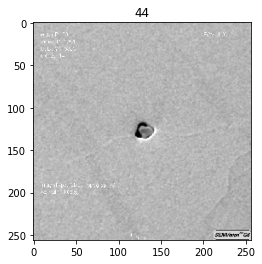

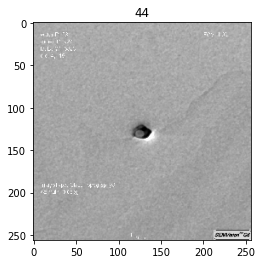

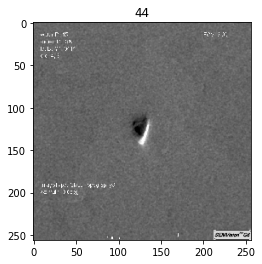

In [63]:
show(test_generator, target=44)

# **Data**

In [4]:
# path for the dataframe with the name and label of each image
csv_path = "/kaggle/input/msiam-sigma-dc-2223/new_train.csv"
# path to the folder containing the training images in a jpg format
img_path = "/kaggle/input/msiam-sigma-dc-2223/train_new"

In [5]:
df = pd.read_csv(csv_path)
# Randomizing the rows of our dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
def id2path(image_id):
    image_dir = r"/kaggle/input/msiam-sigma-dc-2223/train_new"
    image_path = os.path.join(image_dir, image_id) + ".jpg"
    return image_path

In [7]:
df["path"] = df["id"].apply(id2path)
df["label"] = df["label"].astype(str)

In [8]:
def add_noise(image):
    return image + abs(np.random.randn(256,256,3)*255/5)

In [8]:
from sklearn.decomposition import PCA
def add_pca_noise(image):
    # Split the image into its color channels
    b, g, r = cv2.split(image)

    # Add noise to each channel using PCA
    pca = PCA(n_components=0.70, svd_solver='full')
    b_noisy = pca.fit_transform(b.flatten().reshape(-1, 1)).reshape(b.shape)

    # Combine the noisy channels back into a single image
    noisy_image = cv2.merge((b_noisy, b_noisy, b_noisy))
    
    return noisy_image

In [ ]:
# Split the data into a training set and a validation set
train_df, val_df = train_test_split(df, test_size=0.2, shuffle = False)

# Create a data generator object to generate training and validation data
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip = True, rotation_range=40, brightness_range=(0.6,1.4), width_shift_range= 0.2 , height_shift_range=0.2, fill_mode ='reflect')
val_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip = True, rotation_range=40, brightness_range=(0.6,1.4), width_shift_range= 0.2 , height_shift_range=0.2, fill_mode ='reflect')
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator that reads data from the dataframe and generates batches of data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="label",
    target_size=(256, 256),
    batch_size=64,
    class_mode="categorical",
    color_mode = "rgb",
    seed = 123)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="path",
    y_col="label",
    target_size=(256, 256),
    batch_size=64,
    class_mode="categorical",
    color_mode = "rgb",
    seed = 123)


test_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="path",
    y_col="label",
    target_size=(256, 256),
    batch_size=1600,
    class_mode="categorical",
    color_mode = "rgb",
    seed = 123)


In [11]:
def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y

# **Using CutMix DataGenerator**

In [143]:
!pip install cutmix-keras

In [144]:
from cutmix_keras import CutMixImageDataGenerator 

In [145]:
train_generator_1 = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="label",
    target_size=(256, 256),
    batch_size=64,
    class_mode="categorical",
    color_mode = "rgb",
    seed = 123)

train_generator_2 = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="label",
    target_size=(256, 256),
    batch_size=64,
    class_mode="categorical",
    color_mode = "rgb",
    seed = 654130)

cutmix_generator = CutMixImageDataGenerator(
    generator1=train_generator_1,
    generator2=train_generator_2,
    img_size=256,
    batch_size=64,
)

Found 6988 validated image filenames belonging to 8 classes.
Found 6988 validated image filenames belonging to 8 classes.


In [10]:
gc.collect()

23

In [19]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# **Using MixUp DataGenerator**

In [93]:
class MixupImageDataGenerator():
    def __init__(self, generator, dataframe, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.

        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            dataframe {str} -- Dataframe containing the path and label of each image.
            batch_size {int} -- Batch size.

        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha
        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_dataframe(
                                                        dataframe=dataframe,
                                                        x_col="path",
                                                        y_col="label",
                                                        target_size=(256, 256),
                                                        batch_size=batch_size,
                                                        class_mode="categorical",
                                                        color_mode="rgb",
                                                        shuffle = True,
                                                        seed = 32)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_dataframe(
                                                        dataframe=dataframe,
                                                        x_col="path",
                                                        y_col="label",
                                                        target_size=(256, 256),
                                                        batch_size=batch_size,
                                                        class_mode="categorical",
                                                        color_mode = "rgb",
                                                        shuffle = True,
                                                        seed = 20623)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.

        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.

        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

       

        
        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()
        
        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, X1.shape[0])
        
        X_l = l.reshape(X1.shape[0], 1, 1, 1)
        y_l = l.reshape(X1.shape[0], 1)

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [94]:
# Create a generator that reads data from the dataframe and generates batches of data
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip = True, rotation_range=40, brightness_range=(0.5,1.5), fill_mode='reflect')

mixup_generator = MixupImageDataGenerator(generator=train_datagen,
                                          dataframe = train_df,
                                          batch_size=64,
                                          img_height=256,
                                          img_width=256,
                                          subset='training')

Found 6988 validated image filenames belonging to 8 classes.
Found 6988 validated image filenames belonging to 8 classes.


In [ ]:
show(mixup_generator, 41)

# **Inception**

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_precision', factor=0.1, patience=10)

In [13]:
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.1
    return lr


callback = LearningRateScheduler(scheduler)

**Defining the model**

In [18]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights = 'imagenet', input_shape=(256,256,3))
Inception = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [20]:
adam_3 = Adam(learning_rate=0.0001)
Inception.compile(optimizer= adam_3, loss='categorical_crossentropy', metrics=['accuracy','Precision', 'Recall'])
Inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2056      
Total params: 22,985,256
Trainable params: 22,950,824
Non-trainable params: 34,432
_________________________________________________________________


In [19]:
# This was to conserve the weights when adding a new layer
Inception.layers[0].set_weights(Inception_11.layers[0].get_weights())

**Loading the trained model**

In [12]:
Inception_12 = load_model(r"/kaggle/input/second-wm/Inception_12.hdf5")
Inception_12.optimizer.learning_rate

In [19]:
# If we want to change the learning rate of the model
K.set_value(Inception_12.optimizer.learning_rate, 10**-4)

**TensorBoard**

In [ ]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

**Training the model**

In [79]:
gc.collect()

138167

In [80]:
model_checkpoint = ModelCheckpoint('Inception_1.hdf5',save_best_only = True)
history = Inception_12.fit(
        train_generator,
        validation_data = val_generator,
        steps_per_epoch=len(train_generator)//2,
        epochs=20,
        callbacks = [model_checkpoint, tensorboard_callback])

Epoch 1/20
 1/55 [..............................] - ETA: 1:26 - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

2023-01-09 17:56:06.384708: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-09 17:56:06.384769: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/55 [>.............................] - ETA: 1:26 - loss: 0.0227 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922

2023-01-09 17:56:07.815939: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-09 17:56:07.819014: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-09 17:56:07.993941: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2357 callback api events and 2352 activity events. 
2023-01-09 17:56:08.073597: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-09 17:56:08.171370: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20230109-172100/train/plugins/profile/2023_01_09_17_56_08

2023-01-09 17:56:08.232339: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20230109-172100/train/plugins/profile/2023_01_09_17_56_08/07d74848e480.trace.json.gz
2023-01-09 17:56:08.350107: I tensorflow/core/profiler/rpc/client/save_profile.c

55/55 [==============================] - 117s 2s/step - loss: 0.0423 - accuracy: 0.9890 - precision: 0.9905 - recall: 0.9882 - val_loss: 0.0512 - val_accuracy: 0.9863 - val_precision: 0.9868 - val_recall: 0.9863
Epoch 2/20
55/55 [==============================] - 114s 2s/step - loss: 0.0440 - accuracy: 0.9882 - precision: 0.9893 - recall: 0.9882 - val_loss: 0.0373 - val_accuracy: 0.9914 - val_precision: 0.9926 - val_recall: 0.9914
Epoch 3/20
55/55 [==============================] - 120s 2s/step - loss: 0.0340 - accuracy: 0.9918 - precision: 0.9923 - recall: 0.9915 - val_loss: 0.0342 - val_accuracy: 0.9908 - val_precision: 0.9908 - val_recall: 0.9897
Epoch 4/20
55/55 [==============================] - 117s 2s/step - loss: 0.0362 - accuracy: 0.9912 - precision: 0.9915 - recall: 0.9906 - val_loss: 0.0482 - val_accuracy: 0.9880 - val_precision: 0.9880 - val_recall: 0.9880
Epoch 5/20
55/55 [==============================] - 116s 2s/step - loss: 0.0366 - accuracy: 0.9893 - precision: 0.9896 

**Evaluating the model**

In [81]:
t_x, t_y = test_generator.next()
gc.collect()

23

In [88]:
vfvf.evaluate(t_x,t_y)

5/5 [==============================] - 2s 60ms/step - loss: 0.0467 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865


[0.04665612056851387,
 0.9864864945411682,
 0.9864864945411682,
 0.9864864945411682]

In [89]:
Inception_12.evaluate(t_x,t_y)

5/5 [==============================] - 0s 62ms/step - loss: 0.0372 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932


[0.037169817835092545,
 0.9932432174682617,
 0.9932432174682617,
 0.9932432174682617]

In [87]:
vfvf = load_model("/kaggle/working/Inception_1.hdf5")

# **DenseNet-201**

In [9]:
base_model = tf.keras.applications.densenet.DenseNet201(include_top=False, weights = 'imagenet', input_shape=(256,256,3))
DenseNet = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dense(8, activation='softmax')
])
# Compiling the model
DenseNet.compile(optimizer = Adam(learning_rate=10**-3), loss = 'categorical_crossentropy', metrics=['accuracy','Precision', 'Recall'])

2023-01-08 19:31:00.239337: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


74850304/74836368 [==============================] - 3s 0us/step


In [10]:
# Saving the best model
model_checkpoint = ModelCheckpoint('DenseNet.hdf5', monitor='val_precision', mode='max', save_best_only = True)
# Lr scheduler
from keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_precision', factor=0.1, patience=10)

In [11]:
gc.collect()

26533

In [ ]:
history = DenseNet.fit(
        train_generator,
        validation_data= val_generator,
        steps_per_epoch=len(train_generator),
        epochs=1,
        callbacks = [model_checkpoint, lr_scheduler])

2023-01-08 19:31:12.896529: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


 74/110 [===================>..........] - ETA: 16:44 - loss: 0.9553 - accuracy: 0.7972 - precision: 0.8669 - recall: 0.7357

# **Finding the optimal Learning Rate**

In [66]:
gc.collect()

23

In [160]:
Imception = load_model("/kaggle/working/Imception.hdf5")

In [162]:
Imception_clone = load_model("/kaggle/working/Imception.hdf5")

In [161]:
Imception.evaluate(val_generator)

28/28 [==============================] - 15s 448ms/step - loss: 0.1520 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731


[0.1519968956708908,
 0.9731121063232422,
 0.9731121063232422,
 0.9731121063232422]

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def f(model):
    # Set a list to hold the learning rates and losses
    learning_rates = []
    losses = []

    lr = 10**-10
    # Iterate over a range of learning rates
    for i in range(50):
        # Making sure every model has the same weights at the start
        model_copy.set_weights(Imception.get_weights())
        #import ipdb; ipdb.set_trace()
        # Set the learning rate for the optimizer
        K.set_value(model.optimizer.learning_rate, lr)
        print(model.optimizer.learning_rate.numpy())
        train_data, train_labels = train_generator.next()
        # Train the model for one epoch
        train_loss, train_acc = model.train_on_batch(train_data, train_labels)[:2]

        # Evaluate the model on the validation data
        evaluation = model.evaluate(val_generator, return_dict=True)
        val_loss, val_acc = evaluation['loss'], evaluation['accuracy']

        # Record the learning rate and loss
        learning_rates.append(lr)
        losses.append((train_loss, val_loss))

        # Increase the learning rate exponentially
        lr *= 1.55

    # Plot the learning rate vs. loss
    plt.plot(learning_rates, losses)
    plt.xscale('log')
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')
    plt.show()


f(Imception_clone)


# **EfficientNetB5**

In [ ]:
previous = load_model(r"/kaggle/input/wafermaps/Incept_6.hdf5")

In [ ]:
prev_weights = previous.get_weights()

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights = 'imagenet', input_shape=(256,256,3))
Efficient = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [ ]:
adam_3 = Adam(learning_rate=0.001)
Efficient.compile(optimizer= adam_3, loss='categorical_crossentropy', metrics=['accuracy','Precision', 'Recall'])

In [ ]:
Efficient.summary()

# **ResNet101**

In [ ]:
from tensorflow.keras.applications import ResNet101

In [ ]:
base_model = tf.keras.applications.resnet.ResNet101(include_top=False, weights = 'imagenet', input_shape=(256,256,3))

ResNet = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(8, activation='softmax')
])

adam_3 = Adam(learning_rate=0.00001)
ResNet.compile(optimizer= adam_3, loss='categorical_crossentropy', metrics=['accuracy','Precision', 'Recall'])

In [ ]:
ResNet.summary()

# Fitting the model

**Freezing the base model weights**

In [ ]:
ResNet.layers[0].trainable = False 

In [ ]:
for lnum, layer in enumerate(ResNet.layers):
    print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
gc.collect()

**Training**

In [ ]:
model_checkpoint = ModelCheckpoint('ResNet.hdf5', save_best_only = True, monitor="precision", mode="max")
history = ResNet.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=20,
        validation_data=val_generator,
        callbacks = [model_checkpoint])

**Plotting precision/epochs**

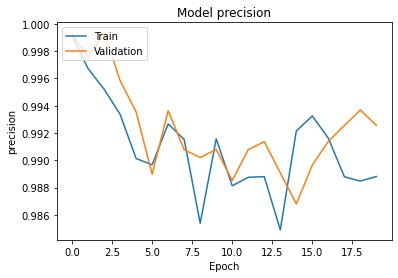

In [30]:
import matplotlib.pyplot as plt

# Plot the model's accuracy over time
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Plotting Confusion Matrix**

In [12]:
l2d = {0 : ["non-visible default", 1], 1 : ["small residue", 20], 2 :["large residue", 21], 3:["C residue", 22], 4:["BEOL", 32], 5:["scratch", 41], 6:["small missing cupper", 44], 7:["large missing cupper", 45], 8:["insufficient confidence in prediction", 99] }

# Defect class to integer label ranging from 0 to 8
d2l = {}
for key, value in l2d.items():
    d2l[value[1]] = key
    
def to_categ(labels):
    # One hot encoding for labels
    ulabels = list(map(lambda elt:d2l[elt],labels))
    ulabels = tf.keras.utils.to_categorical(ulabels)
    return ulabels

In [13]:
inverted_dict = dict((v, k) for k, v in d2l.items())
def to_normal(y):
    """
    This function converts an array of one hot encoded vectors to their corresponding labels
    @param y: numpy array, an array of one hot encoded vectors
    @return: numpy array, an array of integers representing the labels corresponding to the one hot encoded vectors.
    
    Example:
        y = [[0, 0, 1], [1, 0, 0]]
        to_normal(y)
        > [20, 1]
    """
    return np.array(list(map(lambda x:inverted_dict[np.argmax(x)],y)))

def plot_cm(model, gen):
    #import ipdb; ipdb.set_trace()
    # Getting the data
    X, y = gen.next()
    # Defining true and predicted values
    y_pred = to_normal(model.predict(X))
    y_true = to_normal(y)
    # create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels = list(set(y_true)))
    # Plotting the confusion matrix
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=list(set(y_true)))
    cmd_obj.plot()

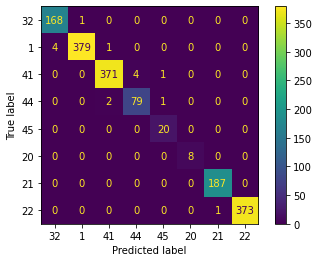

In [86]:
plot_cm(Inception_12, test_generator)

# **Submitting our results**

In [149]:
test_model = load_model(r"/kaggle/working/Inception_151.hdf5")

In [14]:
def create_dataset(training_df, image_dir):
    """
    This function takes the training dataframe
    and outputs training array and labels
    :param training_df: dataframe with id, label columns
    :param image_dir: location of images (folder), string
    :return: X, y (training array with features and labels)
    """
    # create empty list to store image vectors
    images = []
    # create empty list to store labels
    labels = []

    for index, row in tqdm(training_df.iterrows(),total=len(training_df),desc="processing images"):
        # get image id
        image_id = row["id"]
        # create image path
        image_path = os.path.join(image_dir, image_id)
        # open image using PIL
        image = Image.open(image_path + ".jpg")
        # resize image to 256x256. we use bilinear resampling
        image = image.resize((256, 256), resample=Image.Resampling.BILINEAR)
        # convert image to array and normalizing the image
        image = np.array(image)/255
        # ravel
        #image = image.ravel()
        # Reducing the size of an image
        image = image.astype(np.float16)
        # append images and labels lists
        images.append(image)
        labels.append(int(row["label"]))
    # convert list of list of images to numpy array
    images = np.array(images)
    # print size of this array
    print(images.shape)
    return np.stack([images, images, images], axis=-1), labels

In [15]:
t_csv_path = "/kaggle/input/msiam-sigma-dc-2223/test_kaggle.csv"
t_img_path = "/kaggle/input/msiam-sigma-dc-2223/test_new"
t_df = pd.read_csv(t_csv_path)
t_df.label = t_df.label.apply(lambda x:0)
t_df

,id,label
0,002d03daead5ed8ed8086d621b85a178e8659f5413c36e...,0
1,00534cbcb398f307be932f9248ce5471d74256a4ff932b...,0
2,00d473b2ad2987430a2e54143c35a27b0eb61d565ba6eb...,0
3,00e68600c95d271ddb8983d8279f23d63421cf84e17bed...,0
4,0102ccd70362294ee13f1bbfca30a50cac686888b3d26f...,0
...,...,...
1541,fec69070e73c985c59e5b27e72d49c80fd420d9ae65e12...,0
1542,fecf88a6457dedd7b29da8bfa71cabe76ba281f960187b...,0
1543,feda5f1ab5c4a84507c843a6afb2bb7aad00d633849028...,0
1544,ff90460cd3767b0737dc3421714d51d072bf89a3c83ac9...,0


In [16]:
# Importing the test images
t_images, t_labels = create_dataset(t_df,t_img_path)
t_images =  t_images.reshape(1546, 256, 256, 3)

processing images: 100%|██████████| 1546/1546 [00:22<00:00, 69.96it/s]


(1546, 256, 256)


In [17]:
def submit(model, file_name):
    for idx, image in tqdm(enumerate(t_images)):
        prediction = model.predict(image.reshape(1,256,256,3))
        predicted_class_label = l2d[np.argmax(prediction)][1]
        t_df.label[idx] = predicted_class_label
    # Renaming the columns
    # Saving the dataframe to the output
    t_df.to_csv(file_name, index=False)
    return t_df

# **Finding the best model**

In [ ]:
Inception_13 = load_model(r"/kaggle/input/second-wm/Inception_13.hdf5")

In [25]:
Hoping = load_model(r"/kaggle/input/hoping/Inception_13.hdf5")

In [90]:
t_df_9 = submit(Inception_12, "lastone.csv")

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
1546it [01:19, 19.46it/s]


In [32]:
check_df(t_df_9)

All labels are the same in both dataframes


In [35]:
t_x,t_y = test_generator.next()

In [44]:
Inception_14 = load_model(r"/kaggle/input/second-wm/Inception_14.hdf5")

In [39]:
# Inception13
Hoping.evaluate(t_x,t_y)

2023-01-09 17:02:32.832010: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1258291200 exceeds 10% of free system memory.


50/50 [==============================] - 3s 69ms/step - loss: 0.1551 - accuracy: 0.9787 - precision: 0.9904 - recall: 0.9681


[0.15513500571250916,
 0.9787499904632568,
 0.9904091954231262,
 0.9681249856948853]

In [41]:
Inception_11.evaluate(t_x,t_y)

50/50 [==============================] - 5s 65ms/step - loss: 0.0849 - accuracy: 0.9800 - precision: 0.9806 - recall: 0.9794


[0.08491319417953491,
 0.9800000190734863,
 0.9806007742881775,
 0.9793750047683716]

In [83]:
Inception_12.evaluate(t_x,t_y)

5/5 [==============================] - 0s 58ms/step - loss: 0.0372 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932


[0.037169817835092545,
 0.9932432174682617,
 0.9932432174682617,
 0.9932432174682617]

In [45]:
Inception_14.evaluate(t_x,t_y)

50/50 [==============================] - 5s 64ms/step - loss: 0.0997 - accuracy: 0.9844 - precision: 0.9905 - recall: 0.9787


[0.09968908131122589, 0.984375, 0.9905123114585876, 0.9787499904632568]

In [95]:
for i in range(3,8):
    check_df = pd.read_csv(f"/kaggle/input/second-wm/Inception_{i}.csv")
    if Counter(t_df.label) == Counter(check_df.label):
        print(f"Yes, it is Inception_{i} ")
print("Oh ! none")

Yes, it is Inception_5 
Oh ! none


In [96]:
check_df = pd.read_csv(f"/kaggle/input/second-wm/Inception_5.csv")

In [99]:
Counter(t_df.label) == Counter(check_df.label)

True

In [67]:
Counter(t_df.label) == Counter(best_sub.label)

False

In [31]:
def check_df(check_df):
    df_merged = t_df_13.merge(check_df, on = "id")
    if (df_merged['label_x'] == df_merged['label_y']).all():
      print("All labels are the same in both dataframes")
    else:
      print("Not all labels are the same in both dataframes")

In [23]:
best_sub = pd.read_csv("/kaggle/input/dvsdvdvd/Inception_3 (6).csv")

In [91]:
Counter(t_df_9.label)

Counter({22: 369, 41: 342, 1: 377, 21: 168, 45: 23, 32: 167, 44: 89, 20: 11})

In [33]:
Counter(best_sub.label)

Counter({20: 9, 22: 368, 21: 167, 32: 174, 44: 82, 1: 376, 45: 23, 41: 347})

In [94]:
Inception_12.save('best.hdf5')
